# ____________________________________________________
# PHASE II : FEATURE ENGINEERING AND MODEL BUILDING
# ____________________________________________________
# 

# IMPORTING LIBRARIES
##### 

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier , RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# INITIATING MACHINE INSTANCES

In [26]:
lr,rg,dt,rf,ad,gb,xg,gn,ca = LogisticRegression(),RidgeClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),\
GradientBoostingClassifier(),XGBClassifier(),GaussianNB(),CatBoostClassifier(verbose=0)

In [7]:
# Using data of 2017 and 2018

df = pd.concat((pd.read_csv("df2017.csv"),pd.read_csv("df2018.csv")),ignore_index=True)

# DROPPING COLUMNS THAT ARE CREATING DATA LEAKAGE AND ARE IRRELEVANT TO THE TARGET (ALREADY DONE IN THE PHASE 1 EDA)

In [8]:
df.drop(columns = ['int_rate','installment','zip_code','last_pymnt_d','last_credit_pull_d','earliest_cr_line','policy_code',\
                   'title','issue_d','application_type','pymnt_plan','Unnamed: 0','sub_grade','out_prncp','out_prncp_inv',\
                   'grade','recoveries','collection_recovery_fee','total_rec_prncp','last_pymnt_amnt','debt_settlement_flag',\
                  'delinq_amnt','tot_coll_amt','total_pymnt','total_pymnt_inv'],inplace=True)

# 


# FEATURE ENGINEERING

# 

## FEATURE 1
### fico_avg_score: Fico high and fico low scores of each applicant was provided in the dataset. The average of it was taken and the field was named fico_avg_score. While making predictions, Fico Score is taken as input.

In [9]:
# FICO AVERAGE

df['fico_avg'] = (df.fico_range_high + df.fico_range_low)/2
df['last_fico_avg'] = (df.last_fico_range_high + df.last_fico_range_low)/2
df.drop(['fico_range_high', 'fico_range_low','last_fico_range_high','last_fico_range_low'], axis = 1,inplace=True)

## FEATURE 2
### It is the combination of all the features related to the number of accounts of an individual in different categories.

In [10]:
# FEATURE 2

cols_acc2 = ['num_accts_ever_120_pd', 'num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
            'num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats',
            'num_tl_90g_dpd_24m','num_tl_op_past_12m']

df['numb_col_val'] = 0

for i in cols_acc2:
    df['numb_col_val'] = df['numb_col_val'] + df[i]

df.drop(cols_acc2, axis = 1,inplace=True)

## FEATURE 3
### income_to_loan_ratio:  This is the ratio between the loan amount issued and the annual income of the applicant. [income_to_loan_ratio: annual_inc/ loan_amount ]

In [11]:
# FEATURE 3

df['inc_to_loan_ratio'] = df.annual_inc/df.loan_amnt

## FEATURE 4
### credit_line_ratio: This is the ratio between open credit lines in the borrower’s file and the total number of credit lines ever opened in the borrower’s file. [credit_line_ratio = open_acc / total_acc]

In [12]:
# FEATURE 4

df = df[df.open_acc!=0]
df['credit_line_ratio'] = df.total_acc/df.open_acc
del df["total_acc"],df["open_acc"]

## FEATURE 5
### It is an approximate income left with the individual after the person paid the principle amount of the loan for that year.

In [13]:
# FEATURE 5

df['disposable_inc'] = np.where(df.term == '36 months', (df.annual_inc - df.loan_amnt/3), (df.annual_inc - df.loan_amnt/5))

## FEATURE 6
### Dividing the states on the basis of their geographic location.

In [14]:
state_to_region = {
    'CT': 'Northeast',
    'ME': 'Northeast',
    'MA': 'Northeast',
    'NH': 'Northeast',
    'RI': 'Northeast',
    'VT': 'Northeast',
    'NJ': 'Northeast',
    'NY': 'Northeast',
    'PA': 'Northeast',
    'IL': 'Midwest',
    'IN': 'Midwest',
    'MI': 'Midwest',
    'OH': 'Midwest',
    'WI': 'Midwest',
    'IA': 'Midwest',
    'KS': 'Midwest',
    'MN': 'Midwest',
    'MO': 'Midwest',
    'NE': 'Midwest',
    'ND': 'Midwest',
    'SD': 'Midwest',
    'DE': 'South',
    'FL': 'South',
    'GA': 'South',
    'MD': 'South',
    'NC': 'South',
    'SC': 'South',
    'VA': 'South',
    'DC': 'South',
    'WV': 'South',
    'AL': 'South',
    'KY': 'South',
    'MS': 'South',
    'TN': 'South',
    'AR': 'South',
    'LA': 'South',
    'OK': 'South',
    'TX': 'South',
    'AZ': 'West',
    'CO': 'West',
    'ID': 'West',
    'MT': 'West',
    'NV': 'West',
    'NM': 'West',
    'UT': 'West',
    'WY': 'West',
    'AK': 'West',
    'CA': 'West',
    'HI': 'West',
    'OR': 'West',
    'WA': 'West'
}

# Map the 'addr_state' variable to regions using the state_to_region dictionary
df['addr_state'] = df['addr_state'].map(state_to_region)

# 


# STATISTICAL ANALYSIS

# 

### FOR NUMERICAL COLUMNS   -----> TWO SAMPLE TTEST
### FOR CATEGORICAL COLUMNS -----> CHI2_CONTINGENCY TEST

In [15]:
li = []
for i in df.columns:
    if df[i].dtype==object:
        if stats.chi2_contingency(pd.crosstab(df.loan_status,df[i]))[1]>0.05:
            li.append(i)
    else:
        one = df[df.loan_status=='Charged Off'][i]
        zero = df[df.loan_status=='Fully Paid'][i]
        if stats.ttest_ind(zero,one)[1]>0.05:
            li.append(i)
print('THE LIST OF INSIGNIFICANT COLUMNS ------>',li)

THE LIST OF INSIGNIFICANT COLUMNS ------> ['initial_list_status', 'acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd']


## DROPPING THE STATISTICALLY INSIGNIFICANT FEATURES

In [16]:
df.drop(columns=li,inplace=True)

## SPLTTING THE DATA INTO TRAIN AND TEST

In [17]:
from sklearn.model_selection import train_test_split as t

X = df.drop('loan_status',axis=1)
y = pd.Series(np.where(df.loan_status=='Fully Paid',0,1))
xtrain,xtest,ytrain,ytest = t(X,y,test_size=0.30,stratify=y,random_state=7) 

## Using log transformation loan_amnt to reduce the impact of extreme valueus and normalize its distribution.

In [18]:
df.annual_inc = np.log(df.annual_inc)
df.revol_bal  = stats.yeojohnson(df.revol_bal)[0]

In [19]:
df.disposable_inc = np.log(df.disposable_inc)

In [20]:
df.credit_line_ratio = np.log(df.credit_line_ratio)

In [21]:
df.inc_to_loan_ratio = stats.yeojohnson(df.inc_to_loan_ratio)[0]

### By applying min-max scaling, we can transform the features to a similar scale and range. This can help the model to learn from all the features equally, and prevent the larger-scale features from dominating the model. This can lead to better model performance and generalization.

In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
for i in df.select_dtypes(np.number).columns:
    xtrain[i] = sc.fit_transform(pd.DataFrame(xtrain[i]))
    xtest[i]  = sc.transform(pd.DataFrame(xtest[i]))

## Encoding the categorical features
### Factorize encoding can be useful because many of the features are categorical variables that have no inherent order or numerical meaning.

In [23]:
for i in xtrain.select_dtypes('O'):
    xtrain[i] = pd.factorize(xtrain[i])[0]
    xtest[i]  = pd.factorize(xtest[i])[0]

### CHECKING FOR IMBALANCE IN THE DATA

In [24]:
# CHECKING FOR IMBALANCE IN TRAIN DATA

ytrain.value_counts(normalize=True)

0    0.782937
1    0.217063
dtype: float64

### AdaSyn is a resampling technique that can be used to address class imbalance in datasets, particularly in binary classification problems where the number of examples in one class (e.g., defaulters) is much smaller than the other class (e.g., non-defaulters).

In [25]:
# FIXING THE IMBALANCE USING ADASYN OVER-SAMPLING TECHNIQUE

from imblearn.over_sampling import ADASYN

a = ADASYN()
xtrain,ytrain = a.fit_resample(xtrain,ytrain)

In [27]:
# CHECKING IF THE IMBALANCE IS FIXED

ytrain.value_counts(normalize=True)

# Fixed

0    0.509425
1    0.490575
dtype: float64

## CREATING A FUNCTION TO EVALUATE THE PREDICTIONS ON BOTH TRAINING AND TESTING DATA

In [33]:
def model_info(X_train, X_test, y_train, y_test):
    li1,li2=[],[]
    for model in [lr,rg,dt,rf,gn,ad,gb,xg,ca]:
        model.fit(X_train, y_train)
        X_train_pred = model.predict(X_train)
        X_test_pred = model.predict(X_test)
        li1.append([accuracy_score(y_train, X_train_pred),precision_score(y_train, X_train_pred),\
        recall_score(y_train, X_train_pred),f1_score(y_train, X_train_pred),roc_auc_score(y_train,X_train_pred)])
        li2.append([accuracy_score(y_test, X_test_pred),precision_score(y_test, X_test_pred),\
        recall_score(y_test, X_test_pred),f1_score(y_test, X_test_pred),roc_auc_score(y_test,X_test_pred)])
        global metric
        metric = []
        metric.append([li1,li2])

# BUILDING MODELS AND EVALUATING ON THE BASIS OF MODEL METRICS

In [34]:
model_info(xtrain,xtest,ytrain,ytest)

In [35]:
# Creating DataFrame of model performances

metrics = np.array(metric).reshape((2,9,5))
evaluation = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1','ROC AUC'])
li = ['Logistic Regression','Ridge Classifier','Decision Tree Classifier','Random Forest Classifier',\
       'Gaussian Naive Bayes','Adaboost Classifier','Gradient Boosting Classifier','XGBoost Classifier','CatBoostClassifier']
for i in range(9):
    eval_df = pd.DataFrame({'Logistic Regression Train':list(metrics[0][i]),\
                     'Logistic Regression Test':list(metrics[1][i])},index=['Accuracy','Precision','Recall','F1',\
                                                                                      'ROC AUC']).T
    eval_df.index = [li[i]+'Train',li[i]+'Test']
    evaluation = pd.concat((evaluation,eval_df))
evaluation

,Accuracy,Precision,Recall,F1,ROC AUC
Logistic RegressionTrain,0.931659,0.927860,0.933251,0.930548,0.931688
Logistic RegressionTest,0.924075,0.775589,0.914950,0.839525,0.920777
Ridge ClassifierTrain,0.926553,0.933961,0.914982,0.924374,0.926339
Ridge ClassifierTest,0.925285,0.793391,0.886700,0.837454,0.911341
Decision Tree ClassifierTrain,1.000000,1.000000,1.000000,1.000000,1.000000
Decision Tree ClassifierTest,0.898083,0.752801,0.789829,0.770870,0.858962
Random Forest ClassifierTrain,0.999988,0.999992,0.999984,0.999988,0.999988
Random Forest ClassifierTest,0.932758,0.810547,0.900758,0.853275,0.921194
Gaussian Naive BayesTrain,0.805869,0.785115,0.831996,0.807876,0.806353
Gaussian Naive BayesTest,0.774544,0.488151,0.796507,0.605322,0.782481


## LOGISTIC REGRESSION MODEL

### INFERENCES :

* The precision on the test set is 77%, which means that out of all the predicted positive cases, only 77% are actually positive. This suggests that the model has a high false positive rate on the test set.

* The recall on the test set is 91%, which means that out of all the actual positive cases, the model correctly identifies 91% of them. This suggests that the model has a lower false negative rate on the test set.

* The F1 score on the test set is83%, which is the harmonic mean of precision and recall. It suggests that the model is performing well on both precision and recall, but there is room for improvement.

# For DT and RF: both of them are overfitting.

# NAIVE BAYES

### INFERENCES :

* The precision on the test set is 48%, which means that out of all the predicted positive cases, 48% are actually positive. This suggests that the model has a very high false positive rate on the test set.

* The recall on the test set is 79%, which means that out of all the actual positive cases, the model correctly identifies 79% of them. This suggests that the model has a moderate false negative rate on the test set.

* The F1 score on the test set is 60%, which is the harmonic mean of precision and recall. It suggests that the model is not performing well on both precision and recall, and hence, there is some room for improvement.

* On the other hand, the model's performance on the training set is also good with a precision of 80%, recall of 78%, and an F1 score of 83%. This suggests that the model is performing well on the training set and is overfitting.

## THE BEST MODEL WITH BASE PARAMETERS IS XGBOOST CLASSIFIER, SO FOR FINAL MODEL WE WILL TUNE IT AND BUILD THE TUNED MODEL.

In [42]:
#xg = XGBClassifier()
#cv = StratifiedKFold(n_splits=5,shuffle=True)
#gs = GridSearchCV(estimator=xg,param_grid={'learning_rate':[0.1*i for i in range(1,11)],'max_depth':[2,3,4,5]},scoring='f1',cv=cv,verbose=3)
#gs.fit(xtrain,ytrain)
#print('BEST PARAMETERS :',gs.best_params_)
xg = XGBClassifier()
model = xg.fit(xtrain,ytrain)
pred_train = model.predict(xtrain)
pred_test = model.predict(xtest)
print('\n')
print('METRICS FOR Train')
print('-----------------')
print('Accuracy         :',accuracy_score(ytrain,pred_train))
print('Precision        :',precision_score(ytrain,pred_train))
print('Recall           :',recall_score(ytrain,pred_train))
print('ROC AUC Score    :',roc_auc_score(ytrain,pred_train))
print('F1 Score         :',f1_score(ytrain,pred_train))
print('\n\n')
print('METRICS FOR Test')
print('----------------')
print('Accuracy         :',accuracy_score(ytest,pred_test))
print('Precision        :',precision_score(ytest,pred_test))
print('Recall           :',recall_score(ytest,pred_test))
print('ROC AUC Score    :',roc_auc_score(ytest,pred_test))
print('F1 Score         :',f1_score(ytest,pred_test))



METRICS FOR Train
-----------------
Accuracy         : 0.9649300460430841
Precision        : 0.9607312395991348
Recall           : 0.9680817752581228
ROC AUC Score    : 0.9649883562848303
F1 Score         : 0.9643925013082693



METRICS FOR Test
----------------
Accuracy         : 0.9393759286775631
Precision        : 0.8501346484539762
Recall           : 0.8749457374695295
ROC AUC Score    : 0.9160921729248072
F1 Score         : 0.8623617693522907


## 
# FINAL MODEL ----> XGBCLASSIFIER WITH DEFAULT PARAMETERS
## 

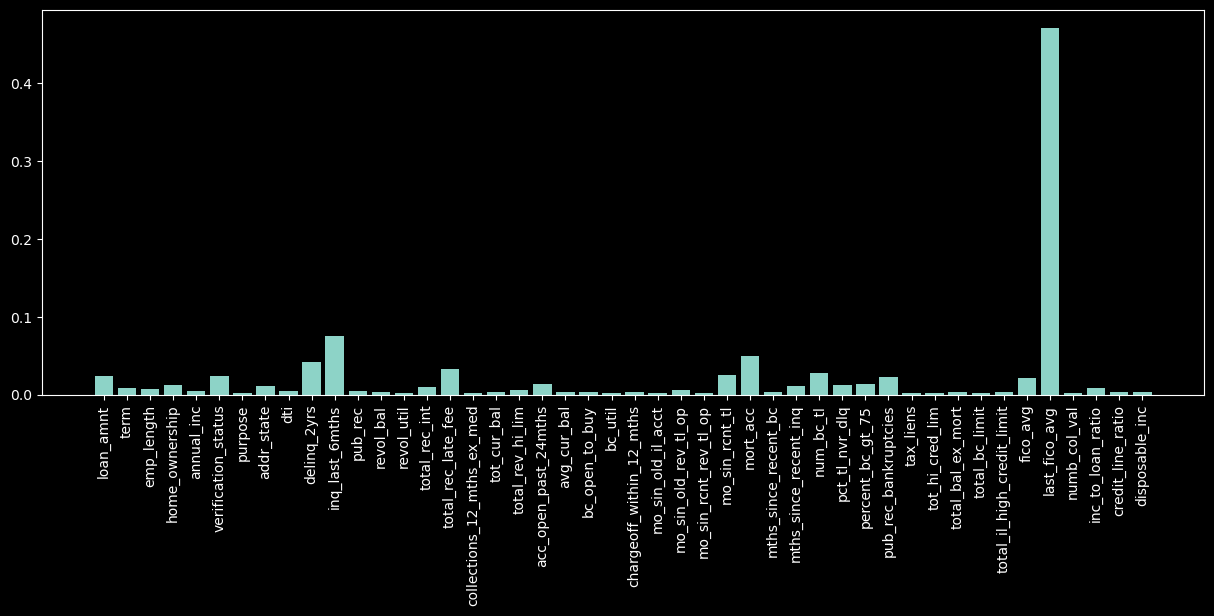

In [45]:
plt.figure(figsize=(15,5))
plt.bar(xtrain.columns,xg.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [46]:
# Most important feature as per the model was last fico average and inquiry in last 6 months.